# Подготовка данных

Загружаем наш обрезанный датасет с размеченными текстами и предпосчитанные векторные представления текстов.

In [3]:
from base.texts import load_sst_df

data, encodings = load_sst_df()
data

,text,label
124,Hart 's War seems to want to be a character st...,0
135,A zippy 96 minutes of mediocre special effects...,0
93,A first-class road movie that proves you can r...,1
179,"It 's super - violent , super-serious and supe...",0
171,Suffers from a flat script and a low budget .,0
...,...,...
56,Both damning and damned compelling .,1
123,"Too much of the movie feels contrived , as if ...",0
40,"The film boasts dry humor and jarring shocks ,...",1
118,The colorful Masseur wastes its time on mood r...,0


# Построение графа текстов

Вычислим дистанции между текстами на основе их векторных представлений и построим модель графа, соединяя рёбрами 500 пар самых близких статей.

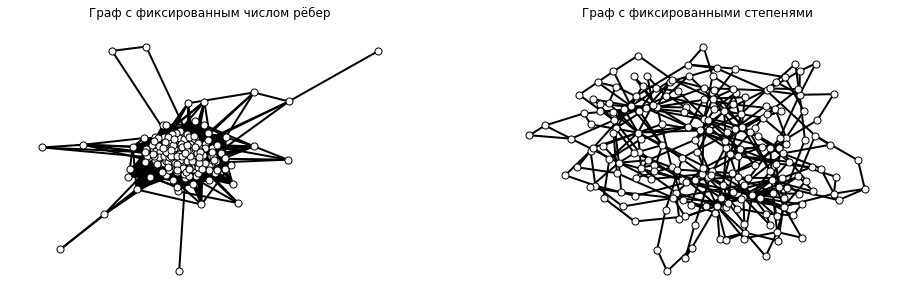

In [10]:
from base.texts import encodings2distances, distances2fixed_edges_graph, distances2fixed_degree_graph
from base.utils import plot_graph
import matplotlib.pyplot as plt

f, ax = plt.subplots(ncols=2, figsize=(16, 5))

distances = encodings2distances(encodings)

G = distances2fixed_edges_graph(distances, 10000, add_single_nodes=True)
plot_graph(G, plot_single_nodes=True, ax=ax[0])
ax[0].set_title("Граф с фиксированным числом рёбер")

G = distances2fixed_degree_graph(distances, 2)
plot_graph(G, plot_single_nodes=True, ax=ax[1])
ax[1].set_title("Граф с фиксированными степенями");

# Бейзлайн: кластеризация текстов на основе эмбеддингов

Какого accuracy добиваются стандартные методы кластеризации, если применить их к векторным представлениям текстов? Усреднение происходит по 100 запускам, в каждом запуске вычисляется максимум из accuracy и 1 - accuracy (так как кластеризация не знает, какому кластеру какая метка соответствует).

In [8]:
from base.texts import clustering_accuracy
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture

kmeans_acc, kmeans_delta = clustering_accuracy(lambda x: KMeans(n_clusters=2).fit_predict(x), 
                                               data["label"], encodings)
gm_acc, gm_delta = clustering_accuracy(lambda x: GaussianMixture(n_components=2).fit_predict(x), 
                                       data["label"], encodings)
sc_acc, sc_delta = clustering_accuracy(lambda x: SpectralClustering(n_clusters=2).fit_predict(x), 
                                       data["label"], encodings)

print(f"Accuracy of K-Means: {kmeans_acc:.3f} ± {kmeans_delta:.3f}")
print(f"Accuracy of Gaussian Mixture: {gm_acc:.3f} ± {gm_delta:.3f}")
print(f"Accuracy of Spectral Clustering: {sc_acc:.3f} ± {sc_delta:.3f}")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of K-Means: 0.549 ± 0.004
Accuracy of Gaussian Mixture: 0.615 ± 0.022
Accuracy of Spectral Clustering: 0.640 ± 0.000


# Кластеризация при помощи graph partitioning

Построим граф на основе расстояний и попробуем кластеризовать его при помощи алгоритма Kernighan–Lin.

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of Kernighan-Lin on fixed degree 2: 0.592 ± 0.011


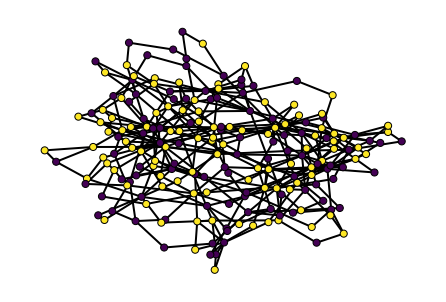

In [11]:
from base.texts import kernighan_lin_clustering, distances2fixed_degree_graph

G = distances2fixed_degree_graph(distances, 2)
kl_acc, kl_delta = clustering_accuracy(kernighan_lin_clustering, data["label"], G)
print(f"Accuracy of Kernighan-Lin on fixed degree 2: {kl_acc:.3f} ± {kl_delta:.3f}")

sample_labels = kernighan_lin_clustering(G)
plot_graph(G, plot_single_nodes=True, node_color=sample_labels)

Найдём качество кластеризации для разных моделей графа и для двух методов разделения графа: Kernighan–Lin и спектральной кластеризации.

In [12]:
import networkx as nx
from tqdm.notebook import tqdm

fixed_edges_kl_accs = []
edges = []

for n_edges in tqdm(np.linspace(1, 20000, 20)):
    n_edges = int(n_edges)
    edges.append(n_edges)
    G = distances2fixed_edges_graph(distances, n_edges, add_single_nodes=True)
    kl_acc, kl_delta = clustering_accuracy(kernighan_lin_clustering, data["label"], G, verbose=False)
    fixed_edges_kl_accs.append(kl_acc)

  0%|          | 0/20 [00:00<?, ?it/s]

In [14]:
import networkx as nx
from tqdm.notebook import tqdm

fixed_degree_kl_accs = []
fixed_degree_sc_accs = []

degrees = [2, 3, 4, 5, 7, 10, 13, 15, 20, 30, 50, 70, 100]

for degree in tqdm(degrees):
    G = distances2fixed_degree_graph(distances, degree)
    kl_acc, kl_delta = clustering_accuracy(kernighan_lin_clustering, data["label"], G, verbose=False)
    fixed_degree_kl_accs.append(kl_acc)
    
    sc_acc, sc_delta = clustering_accuracy(lambda x: SpectralClustering(n_clusters=2, \
        affinity='precomputed').fit_predict(x), data["label"], nx.to_numpy_matrix(G), verbose=False)
    fixed_degree_sc_accs.append(sc_acc)

  0%|          | 0/13 [00:00<?, ?it/s]

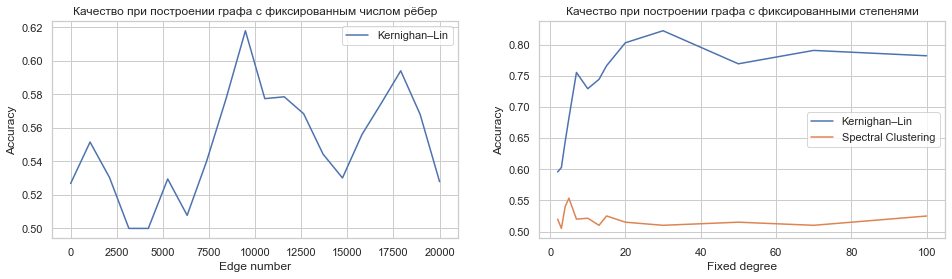

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

f, ax = plt.subplots(ncols=2, figsize=(16, 4))

sns.lineplot(x=edges, y=fixed_edges_kl_accs, label="Kernighan–Lin", ax=ax[0])
ax[0].set_title("Качество при построении графа с фиксированным числом рёбер")
ax[0].set_xlabel("Edge number")
ax[0].set_ylabel("Accuracy")

sns.lineplot(x=degrees, y=fixed_degree_kl_accs, label="Kernighan–Lin", ax=ax[1])
sns.lineplot(x=degrees, y=fixed_degree_sc_accs, label="Spectral Clustering", ax=ax[1])
ax[1].set_title("Качество при построении графа с фиксированными степенями")
ax[1].set_xlabel("Fixed degree")
ax[1].set_ylabel("Accuracy");

# Итоговые результаты

Выберем лучшие модели графа и сравним качество методов на них с качеством бейзлайнов.

In [17]:
from base.texts import clustering_accuracy
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture

kmeans_acc, kmeans_delta = clustering_accuracy(lambda x: KMeans(n_clusters=2).fit_predict(x), 
                                               data["label"], encodings, num_repetitions=100)
gm_acc, gm_delta = clustering_accuracy(lambda x: GaussianMixture(n_components=2).fit_predict(x), 
                                       data["label"], encodings, num_repetitions=100)
sc_acc, sc_delta = clustering_accuracy(lambda x: SpectralClustering(n_clusters=2).fit_predict(x), 
                                       data["label"], encodings, num_repetitions=100)

G = distances2fixed_degree_graph(distances, 30)
kl_acc_deg, kl_delta_deg = clustering_accuracy(kernighan_lin_clustering, data["label"], G,
                                               num_repetitions=100)
sc_acc_deg, sc_delta_deg = clustering_accuracy(lambda x: SpectralClustering(n_clusters=2, \
        affinity='precomputed').fit_predict(x), data["label"], nx.to_numpy_matrix(G), num_repetitions=100)

G = distances2fixed_edges_graph(distances, 10000, add_single_nodes=True)
kl_acc_e, kl_delta_e = clustering_accuracy(kernighan_lin_clustering, data["label"], G,
                                           num_repetitions=100)

print(f"Accuracy of K-Means: {kmeans_acc:.3f}")
print(f"Accuracy of Gaussian Mixture: {gm_acc:.3f}")
print(f"Accuracy of Spectral Clustering: {sc_acc:.3f}")
print(f"Accuracy of Kernighan–Lin on 10000 edges: {kl_acc_e:.3f}")
print(f"Accuracy of Kernighan–Lin on degree 30: {kl_acc_deg:.3f}")
print(f"Accuracy of Spectral Clustering on degree 30: {sc_acc_deg:.3f}")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of K-Means: 0.549
Accuracy of Gaussian Mixture: 0.615
Accuracy of Spectral Clustering: 0.640
Accuracy of Kernighan–Lin on 10000 edges: 0.573
Accuracy of Kernighan–Lin on degree 30: 0.826
Accuracy of Spectral Clustering on degree 30: 0.510
